In [1]:
import tensorflow as tf
import cv2
import os
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
# Set image size and batch size
img_size = 96  # Input size compatible with MobileNetV2
batch_size = 32  # Adjust based on your system's memory capacity

# Paths to dataset directories
train_dir = "Emotion_detection/archive/train"  
test_dir = "Emotion_detection/archive/test"      


In [3]:
# Data Augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,               # Normalize pixel values to [0, 1]
    rotation_range=20,            # Randomly rotate images
    width_shift_range=0.2,        # Randomly shift images horizontally
    height_shift_range=0.2,       # Randomly shift images vertically
    shear_range=0.15,             # Randomly apply shearing transformations
    zoom_range=0.15,              # Randomly zoom in/out
    horizontal_flip=True,         # Randomly flip images horizontally
    fill_mode="nearest"           # Fill missing pixels
)

# Data generator for test set (only normalization)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="sparse"  # Sparse for integer labels
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="sparse",
    shuffle=False  # Keep consistent order for evaluation
)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [4]:
# Load MobileNetV2 with pretrained ImageNet weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False  # Freeze the base model layers

# Add custom layers for FER-2013 classification
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(7, activation='softmax')  # 7 emotion classes
])

# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_96 (Functional)     │ ?                           │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [5]:
# Train the model with frozen base layers
epochs = 11 
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=epochs,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=test_generator.samples // batch_size
)


Epoch 1/11


C:\Users\bhuva\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


897/897 ━━━━━━━━━━━━━━━━━━━━ 598s 646ms/step - accuracy: 0.2755 - loss: 2.0324 - val_accuracy: 0.4042 - val_loss: 1.5419
Epoch 2/11
  1/897 ━━━━━━━━━━━━━━━━━━━━ 3:03 205ms/step - accuracy: 0.3125 - loss: 1.6450

C:\Users\bhuva\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


897/897 ━━━━━━━━━━━━━━━━━━━━ 1s 833us/step - accuracy: 0.3125 - loss: 1.6450 - val_accuracy: 0.5000 - val_loss: 1.8412
Epoch 3/11
897/897 ━━━━━━━━━━━━━━━━━━━━ 265s 294ms/step - accuracy: 0.3732 - loss: 1.6053 - val_accuracy: 0.4255 - val_loss: 1.4979
Epoch 4/11
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step - accuracy: 0.4062 - loss: 1.6509 - val_accuracy: 0.6000 - val_loss: 1.2465
Epoch 5/11
897/897 ━━━━━━━━━━━━━━━━━━━━ 272s 302ms/step - accuracy: 0.3900 - loss: 1.5555 - val_accuracy: 0.4247 - val_loss: 1.4966
Epoch 6/11
897/897 ━━━━━━━━━━━━━━━━━━━━ 1s 228us/step - accuracy: 0.3438 - loss: 1.5661 - val_accuracy: 0.6000 - val_loss: 1.1624
Epoch 7/11
897/897 ━━━━━━━━━━━━━━━━━━━━ 269s 299ms/step - accuracy: 0.4087 - loss: 1.5335 - val_accuracy: 0.4262 - val_loss: 1.4860
Epoch 8/11
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 110us/step - accuracy: 0.6562 - loss: 1.2395 - val_accuracy: 0.6000 - val_loss: 1.4645
Epoch 9/11
897/897 ━━━━━━━━━━━━━━━━━━━━ 265s 294ms/step - accuracy: 0.4105 - loss: 1.5134 - val

In [11]:
# Unfreeze the last few layers of the base model
for layer in base_model.layers[-45:]:  # Adjust the number of layers to unfreeze
    layer.trainable = True

# Recompile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Fine-tune the model
fine_tune_epochs = 10
total_epochs = epochs + fine_tune_epochs
history_fine = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=test_generator.samples // batch_size
)


Epoch 11/21
897/897 ━━━━━━━━━━━━━━━━━━━━ 608s 644ms/step - accuracy: 0.3996 - loss: 1.5457 - val_accuracy: 0.4176 - val_loss: 1.5706
Epoch 12/21
  1/897 ━━━━━━━━━━━━━━━━━━━━ 5:38 377ms/step - accuracy: 0.4375 - loss: 1.3860

C:\Users\bhuva\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


897/897 ━━━━━━━━━━━━━━━━━━━━ 1s 531us/step - accuracy: 0.4375 - loss: 1.3860 - val_accuracy: 0.5000 - val_loss: 1.2639
Epoch 13/21
897/897 ━━━━━━━━━━━━━━━━━━━━ 416s 462ms/step - accuracy: 0.4870 - loss: 1.3483 - val_accuracy: 0.5067 - val_loss: 1.2803
Epoch 14/21
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step - accuracy: 0.6250 - loss: 1.2286 - val_accuracy: 0.7000 - val_loss: 0.7220
Epoch 15/21
897/897 ━━━━━━━━━━━━━━━━━━━━ 404s 449ms/step - accuracy: 0.5162 - loss: 1.2831 - val_accuracy: 0.5314 - val_loss: 1.2196
Epoch 16/21
897/897 ━━━━━━━━━━━━━━━━━━━━ 1s 369us/step - accuracy: 0.4688 - loss: 1.2570 - val_accuracy: 0.6000 - val_loss: 0.8929
Epoch 17/21
897/897 ━━━━━━━━━━━━━━━━━━━━ 405s 450ms/step - accuracy: 0.5417 - loss: 1.2295 - val_accuracy: 0.5426 - val_loss: 1.1910
Epoch 18/21
897/897 ━━━━━━━━━━━━━━━━━━━━ 1s 281us/step - accuracy: 0.5000 - loss: 1.2461 - val_accuracy: 0.8000 - val_loss: 0.4935
Epoch 19/21
897/897 ━━━━━━━━━━━━━━━━━━━━ 406s 452ms/step - accuracy: 0.5583 - loss: 1.189

In [14]:
# Save the final trained model
model.save('emotion_recognition.keras')


In [15]:
# Evaluate model performance on the test set
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


225/225 ━━━━━━━━━━━━━━━━━━━━ 41s 184ms/step - accuracy: 0.4725 - loss: 1.3208
Test Loss: 1.1491426229476929
Test Accuracy: 0.5628308653831482


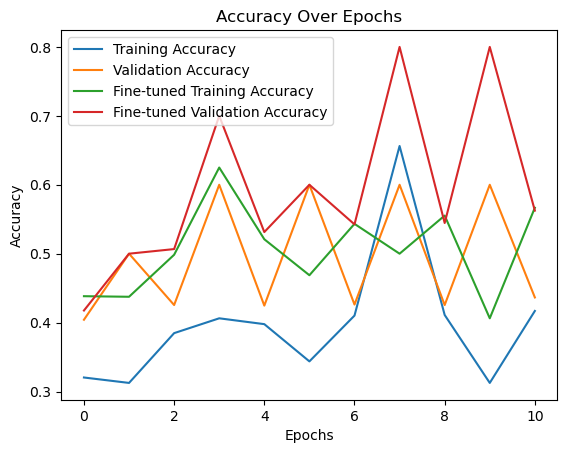

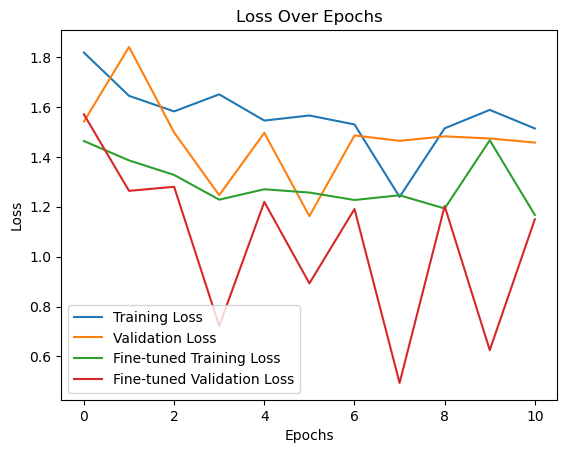

In [16]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_fine.history['accuracy'], label='Fine-tuned Training Accuracy')
plt.plot(history_fine.history['val_accuracy'], label='Fine-tuned Validation Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history_fine.history['loss'], label='Fine-tuned Training Loss')
plt.plot(history_fine.history['val_loss'], label='Fine-tuned Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


In [19]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, classification_report

# Load the trained model
model_path = "emotion_recognition.keras"  # Update the path if needed
model = tf.keras.models.load_model(model_path)

# Define test dataset directory and image size
test_dir = "Emotion_detection/archive/test/"  # Update to your test data directory
img_size = 96  # Should match the size used during training
batch_size = 32

# Prepare the test data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="sparse",  # Use sparse for integer labels
    shuffle=False  # To ensure consistent evaluation
)

# Predict on the test set
y_pred = model.predict(test_generator, verbose=1)
y_pred_classes = y_pred.argmax(axis=1)  # Get predicted class indices
y_true = test_generator.classes  # True labels

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred_classes) * 100
print(f"Test Accuracy: {accuracy:.2f}%")

# Classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=list(test_generator.class_indices.keys())))


Found 7178 images belonging to 7 classes.


C:\Users\bhuva\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


225/225 ━━━━━━━━━━━━━━━━━━━━ 54s 229ms/step
Test Accuracy: 56.28%

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.46      0.47       958
           1       0.65      0.15      0.25       111
           2       0.52      0.14      0.22      1024
           3       0.77      0.81      0.79      1774
           4       0.57      0.43      0.49      1233
           5       0.39      0.67      0.49      1247
           6       0.65      0.75      0.70       831

    accuracy                           0.56      7178
   macro avg       0.57      0.49      0.49      7178
weighted avg       0.58      0.56      0.54      7178

